In [1]:
pwd

'C:\\Users\\aibiz\\Documents\\GitHub\\building_security_data'

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 데이터 파악

In [2]:
# 폴더 경로 설정
folder_path = "./raw data"

# 폴더 안의 파일 리스트 가져오기
file_list = os.listdir(folder_path)

# 필터링 조건을 사용하여 .xlsx 파일만 필터링하여 리스트에 담기
xlsx_file_list = [
    file
    for file in file_list
    if file.endswith("_온도.xlsx") and not file.startswith("~$")
]

print(xlsx_file_list)

['광진구_온도.xlsx', '양주_온도.xlsx', '여수 (1)_온도.xlsx', '여수 (2)_온도.xlsx']


In [3]:
# 엑셀 파일 경로
file_name = xlsx_file_list[0]
print(f"엑셀 파일: {file_name}")
excel_file = f"./raw data/{file_name}"

# 엑셀 파일 열기
xls = pd.ExcelFile(excel_file)

엑셀 파일: 광진구_온도.xlsx


In [4]:
# 센서 정보
xls.sheet_names

['1번 센서', '2번 센서', '3번 센서', '4번 센서', '5번 센서', '6번 센서']

## 총괄 전처리 함수 세팅

In [5]:
# 전처리 함수 : x,y 축 데이터를 시간 스케일에 맞추어 샘플링하는 함수
def preprocess_sampling(sensor, sampling_interval=None, interpolate=None):
    sensor.columns = sensor.iloc[0]
    sensor = sensor[1:]

    sensor = sensor.dropna(subset=["계측시각"])
    sensor_x = sensor.iloc[:, :2]
    sensor_y = sensor.iloc[:, 10:12]
    sensor_temp = sensor[["계측시각", "온도\n(℃)"]].iloc[:, 1:3]

    sensor_xyt = {}

    for sensor_data, sensor_name in [
        (sensor_x, "x"),
        (sensor_y, "y"),
        (sensor_temp, "temp"),
    ]:
        date_idx = pd.to_datetime(sensor_data["계측시각"])
        sensor_data = sensor_data.set_index(date_idx).drop(columns="계측시각").sort_index()
        sensor_data = sensor_data.resample(sampling_interval).first()
        sensor_data = sensor_data.astype(float)
        
        # 선형 보간법 적용
        if interpolate:
            sensor_data = sensor_data.interpolate(method="time")
        # 직전 값 사용
        else:
            sensor_data = sensor_data.fillna(method="ffill")

        sensor_xyt[sensor_name] = sensor_data

    return sensor_xyt


# final 파이프 라인 함수 : 센서별 데이터를 전처리 함수로 일정한 시간간격으로 샘플링 후 결측치 처리하는 함수
def data_pipe_line(sampling_interval):
    folder_path = "./raw data"
    file_list = os.listdir(folder_path)
    xlsx_file_list = [
        file
        for file in file_list
        if file.endswith("_온도.xlsx") and not file.startswith("~$")
    ]

    result_li = []

    for file_name in xlsx_file_list:
        print(f"엑셀 파일: {file_name}")
        excel_file = f"./raw data/{file_name}"
        xls = pd.ExcelFile(excel_file)

        sensor_merge = []

        for sheet_name in xls.sheet_names:
            sensor = pd.read_excel(excel_file, sheet_name=sheet_name)
            sensor_xyt = preprocess_sampling(
                sensor, sampling_interval=sampling_interval, interpolate=False
            )

            series_x = sensor_xyt["x"]
            series_y = sensor_xyt["y"]
            series_temp = sensor_xyt["temp"]

            merged_series = pd.merge(
                series_x, series_y, left_index=True, right_index=True, how="outer"
            ).fillna(method="ffill")
            merged_series = pd.merge(
                merged_series,
                series_temp,
                left_index=True,
                right_index=True,
                how="outer",
            ).fillna(method="ffill")
            merged_series.name = sheet_name

            sensor_merge.append(merged_series)

        sensor_merge_result = (
            pd.concat(sensor_merge, axis=1, keys=xls.sheet_names).ffill().bfill()
        )
        sensor_merge_result.name = file_name

        result_li.append({"file_name": file_name, "data": sensor_merge_result})

    return result_li

## 크롤링 데이터 추가

In [6]:
sampling_interval = "1T"  # 원하는 샘플링 간격 설정
result_list = data_pipe_line(sampling_interval)  # data_pipe_line 함수 호출 및 반환값 저장

엑셀 파일: 광진구_온도.xlsx
엑셀 파일: 양주_온도.xlsx
엑셀 파일: 여수 (1)_온도.xlsx
엑셀 파일: 여수 (2)_온도.xlsx


In [107]:
# viww data
region_dict = {"광진": 0, "양주": 1, "여수_1": 2, "여수_2": 3}
# 지역 설정
region = "여수_2"
dataframe = result_list[region_dict[region]]["data"]
print(dataframe.name)
# 크롤링 data concat
if region.startswith("여수"):
    region = "여수"
dataframe_crawed = pd.read_pickle(f"./크롤링 온도 자료/{region}.pkl")
dataframe_total = pd.concat([dataframe, dataframe_crawed], axis=1)
dataframe_total = dataframe_total.loc[dataframe.index]
dataframe_total_inter = dataframe_total.interpolate(method="time").dropna()
start_index = dataframe_total_inter.index[0]  # First index
end_index = dataframe_total_inter.index[-1]  # Last index
# attack 추가 (디폴트 0)
display(dataframe_total.head(2))
dataframe_total_inter["attack"] = 0
display(dataframe_total_inter.head(2))
print("Start Index:", start_index)
print("End Index:", end_index)
# 저장
dataframe_total_inter.to_csv(
    f"./최종 데이터/{dataframe.name[:-5]}.csv", encoding="utf-8-sig"
)

여수 (2)_온도.xlsx


,"(1번 센서, 계측값\n(deg)_x)","(1번 센서, 계측값\n(deg)_y)","(1번 센서, 온도\n(℃))","(2번 센서, 계측값\n(deg)_x)","(2번 센서, 계측값\n(deg)_y)","(2번 센서, 온도\n(℃))","(3번 센서, 계측값\n(deg)_x)","(3번 센서, 계측값\n(deg)_y)","(3번 센서, 온도\n(℃))",강수60,기온,습도
2022-11-25 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.1,59.0
2022-11-25 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.6,58.0


,"(1번 센서, 계측값\n(deg)_x)","(1번 센서, 계측값\n(deg)_y)","(1번 센서, 온도\n(℃))","(2번 센서, 계측값\n(deg)_x)","(2번 센서, 계측값\n(deg)_y)","(2번 센서, 온도\n(℃))","(3번 센서, 계측값\n(deg)_x)","(3번 센서, 계측값\n(deg)_y)","(3번 센서, 온도\n(℃))",강수60,기온,습도,attack
2023-03-30 14:00:00,0.07,-0.1,32.0,-0.02,0.02,39.0,-0.01,0.01,24.0,0.0,20.00,25.000000,0
2023-03-30 14:01:00,0.07,-0.1,32.0,-0.02,0.02,39.0,-0.01,0.01,24.0,0.0,19.98,25.183333,0


Start Index: 2023-03-30 14:00:00
End Index: 2023-05-11 23:00:00


## 정규화

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def minmax_scaling_columns(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index = df.index)
    return scaled_df, scaler

def minmax_inverse_scaling_columns(scaled_df, scaler):
    restored_data = scaler.inverse_transform(scaled_df)
    restored_df = pd.DataFrame(restored_data, columns=scaled_df.columns, index = scaled_df.index)
    return restored_df

In [8]:
# 예시 데이터 프레임 생성
data = {
    "col1": [1, 2, 3, 4, 5],
    "col2": [10, 20, 30, 40, 50],
    "col3": [100, 200, 300, 400, 500],
}
df = pd.DataFrame(data)

# 각 컬럼 별로 min-max 스케일링 수행
scaled_df, scaler = minmax_scaling_columns(df)

display(scaled_df)

# 데이터 원시 복원
restored_df = minmax_inverse_scaling_columns(scaled_df, scaler)
display(restored_df)

,col1,col2,col3
0,0.00,0.00,0.00
1,0.25,0.25,0.25
2,0.50,0.50,0.50
3,0.75,0.75,0.75
4,1.00,1.00,1.00


,col1,col2,col3
0,1.0,10.0,100.0
1,2.0,20.0,200.0
2,3.0,30.0,300.0
3,4.0,40.0,400.0
4,5.0,50.0,500.0


In [ ]:
df = dataframe_total.copy()
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df["attack"] = 0
df.to_csv(f"./최종 데이터/{dataframe.name[:-5]}_minmax.csv", encoding="utf-8-sig")

## 스케일 후 시각화

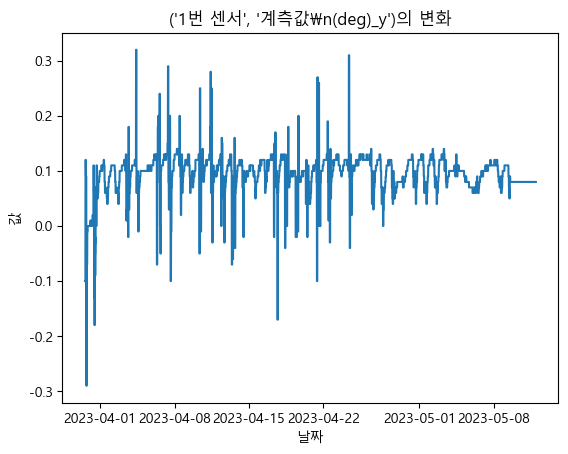

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# 플롯할 열 선택
column_to_plot = df.columns[1]

# 플롯 생성
plt.plot(df.index, df[column_to_plot])

# 플롯 설정
plt.xlabel("날짜")
plt.ylabel("값")
plt.title(f"{column_to_plot}의 변화")

# 플롯 표시
plt.show()

## 센서별 데이터 시각화

엑셀 파일: 광진구_온도.xlsx
엑셀 파일: 양주_온도.xlsx
엑셀 파일: 여수 (1)_온도.xlsx
엑셀 파일: 여수 (2)_온도.xlsx
광진구_온도.xlsx


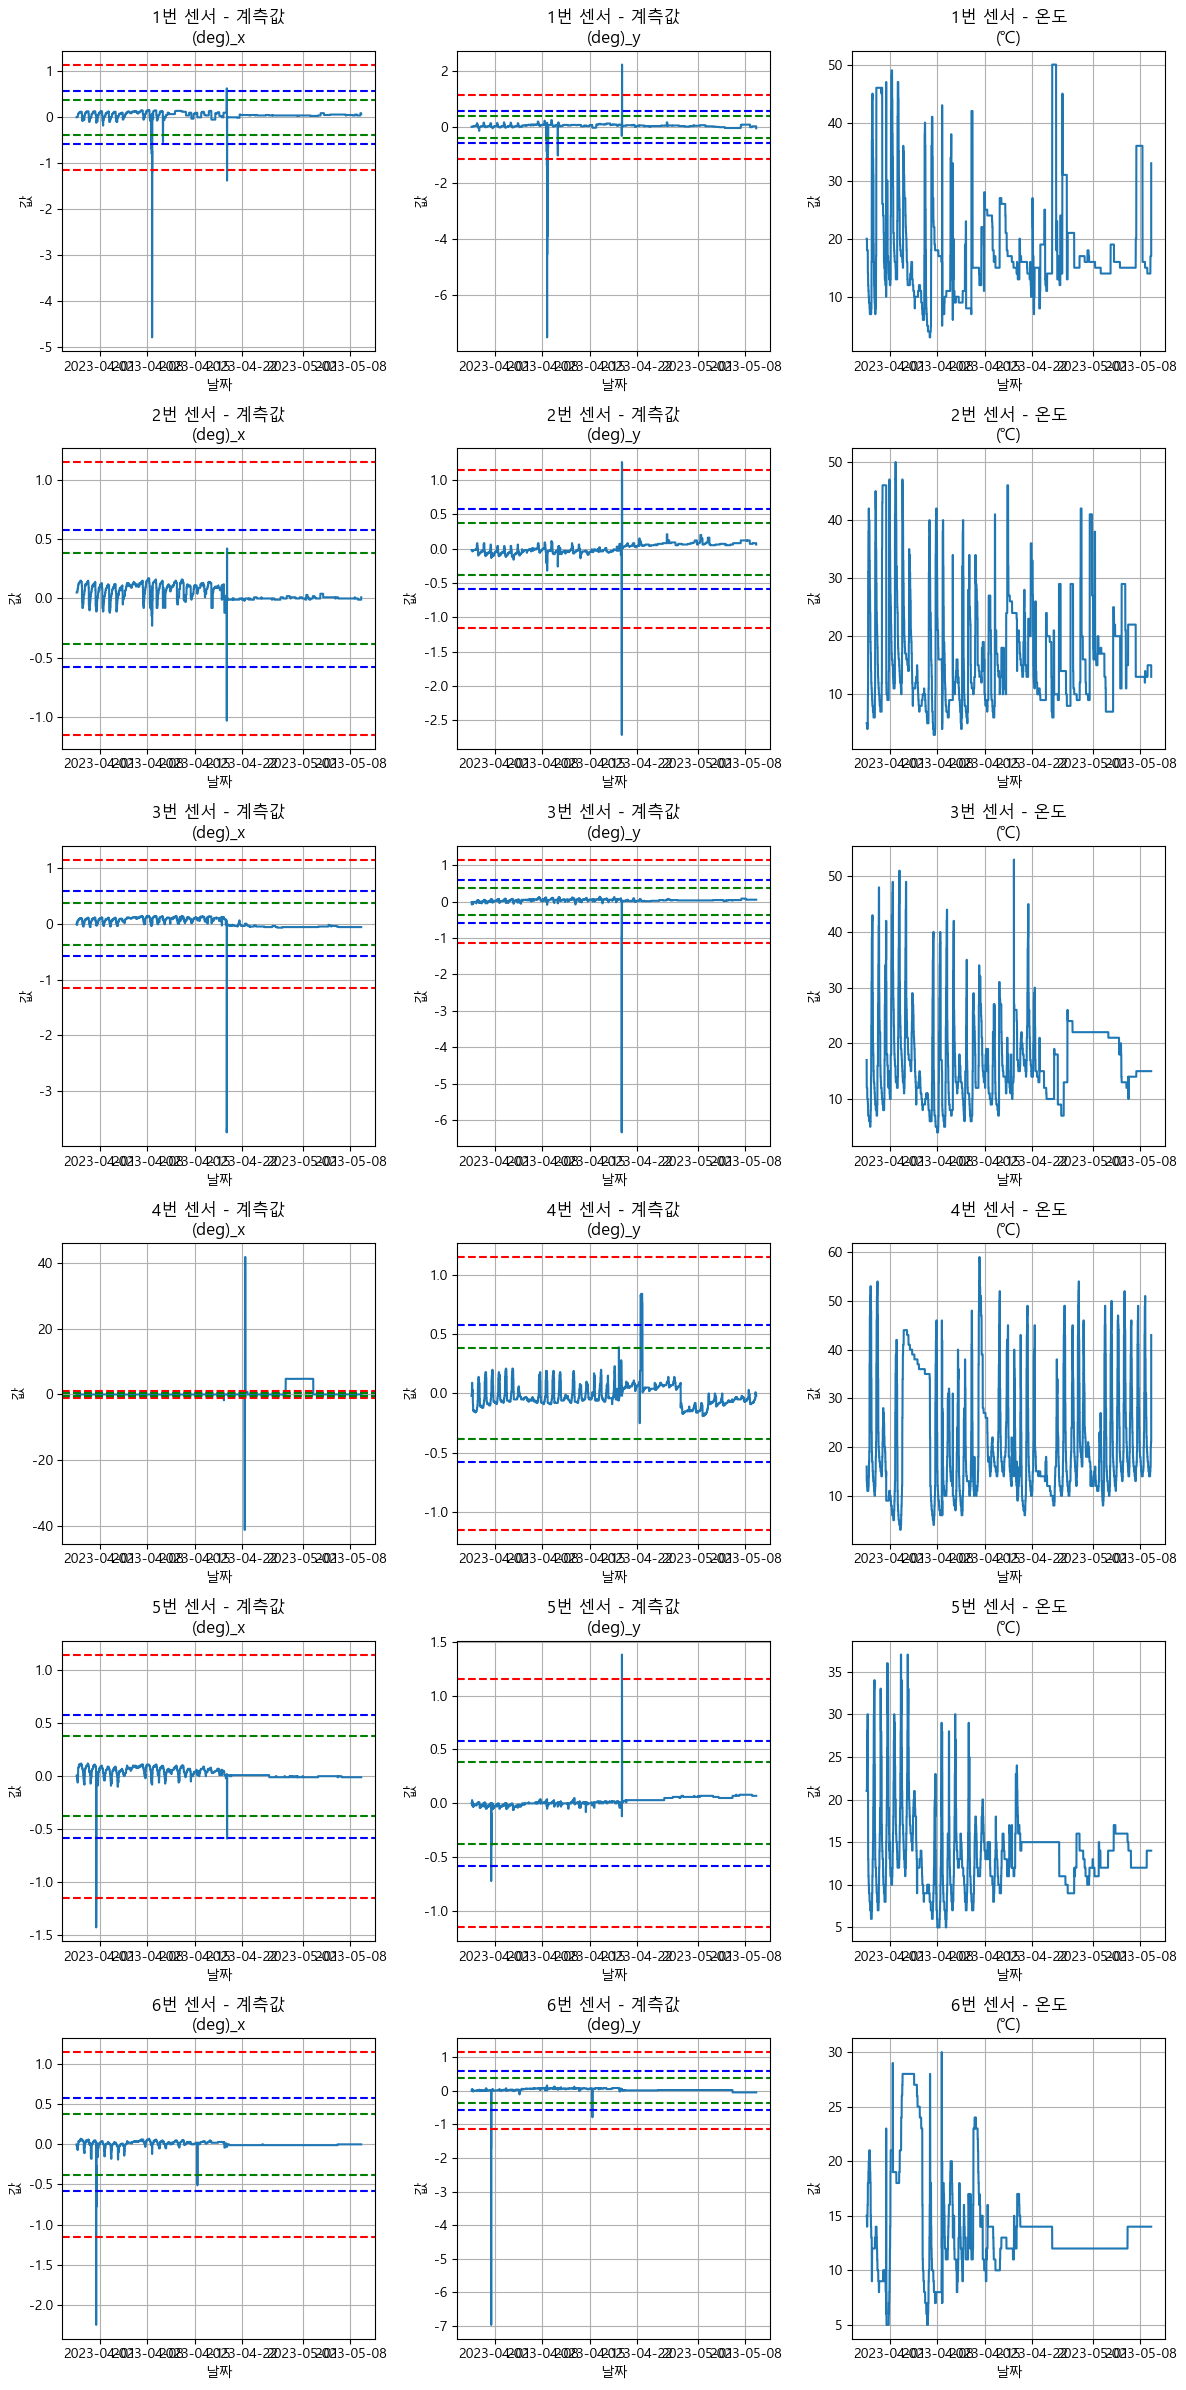

양주_온도.xlsx


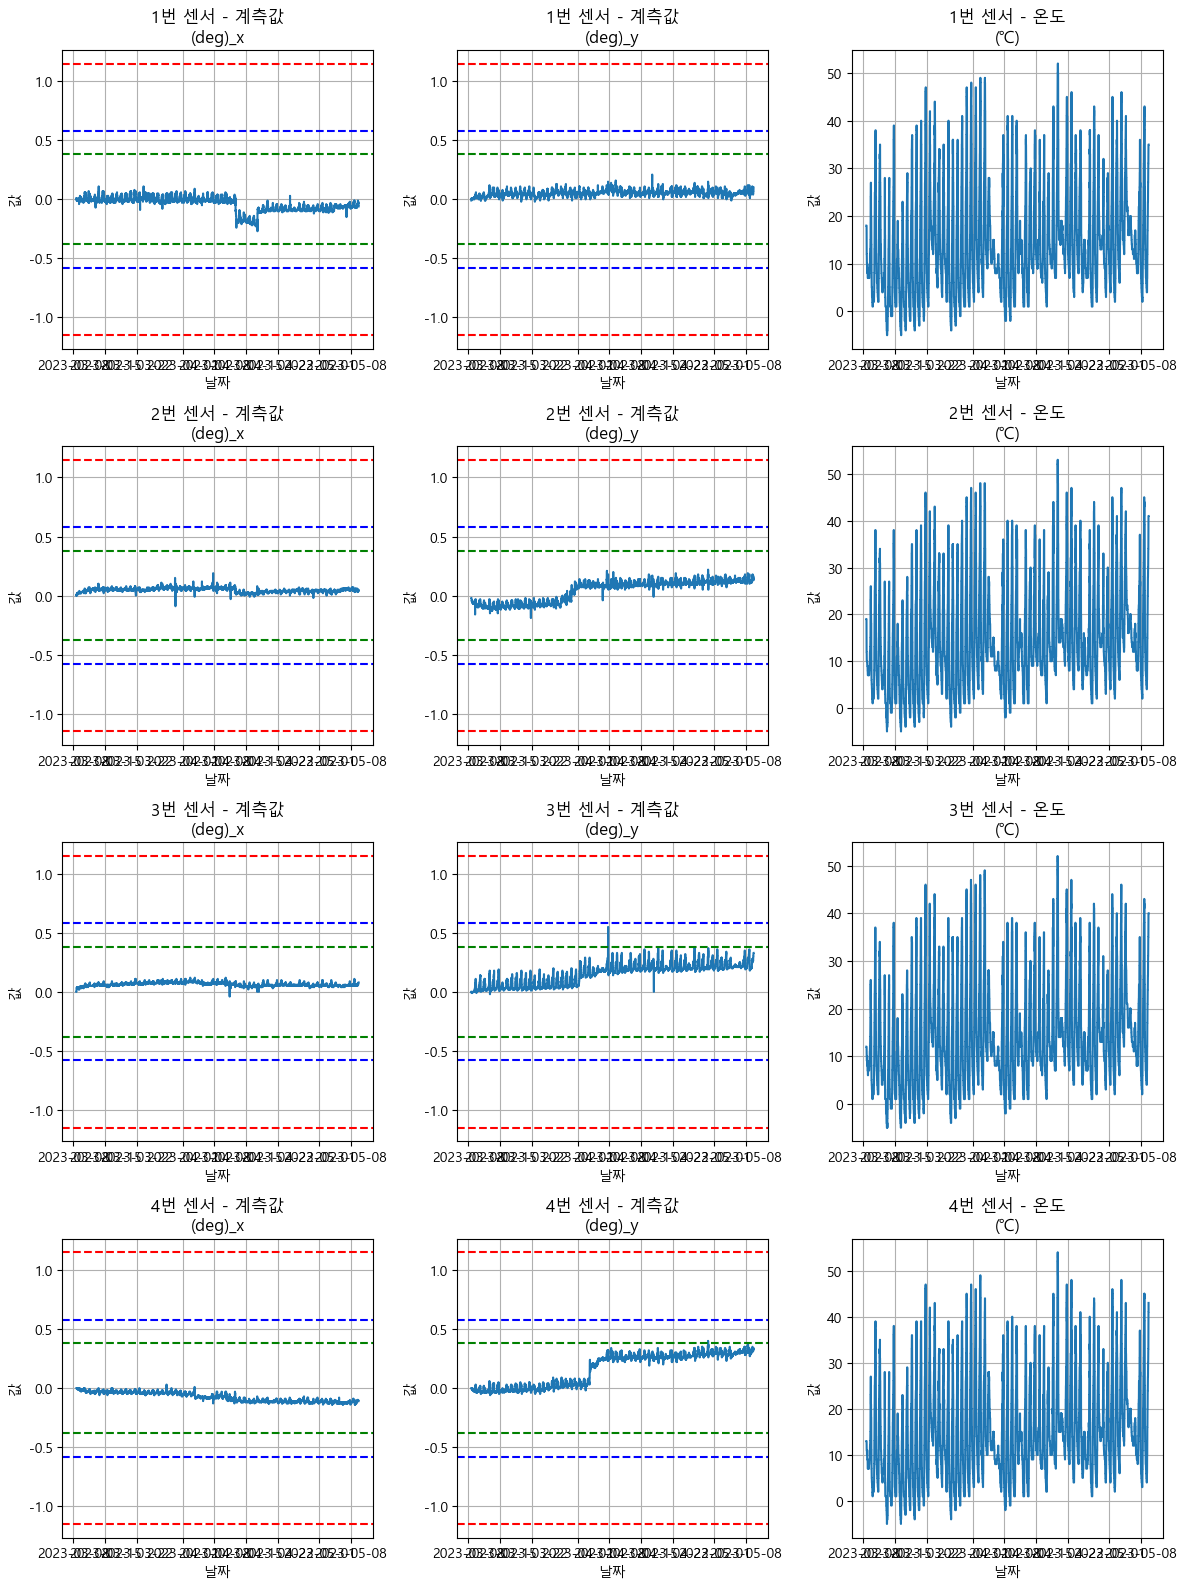

여수 (1)_온도.xlsx


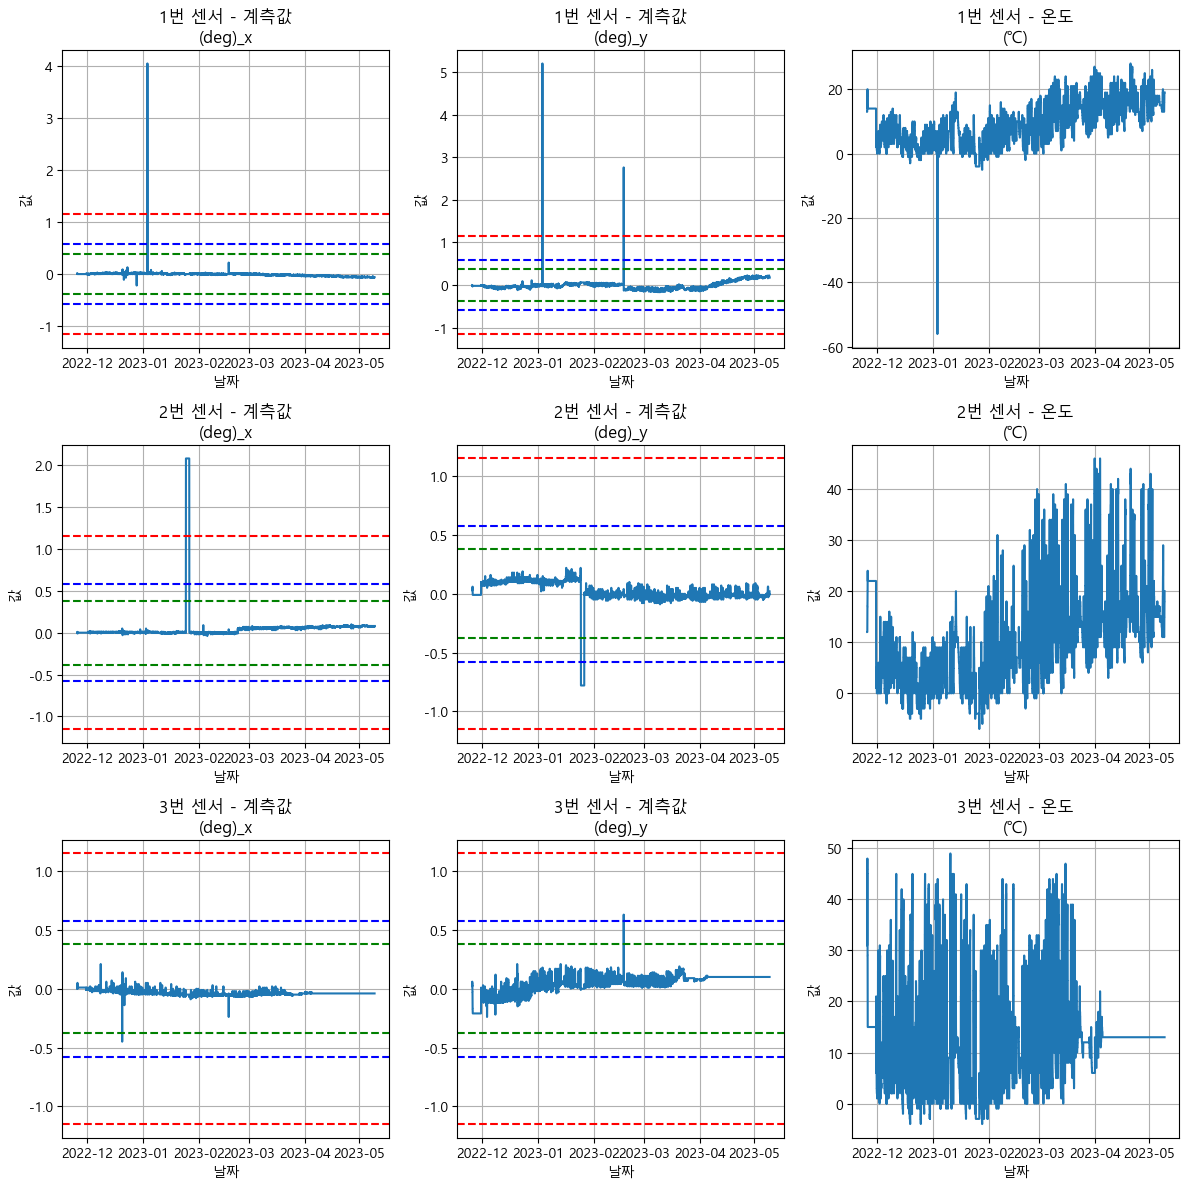

여수 (2)_온도.xlsx


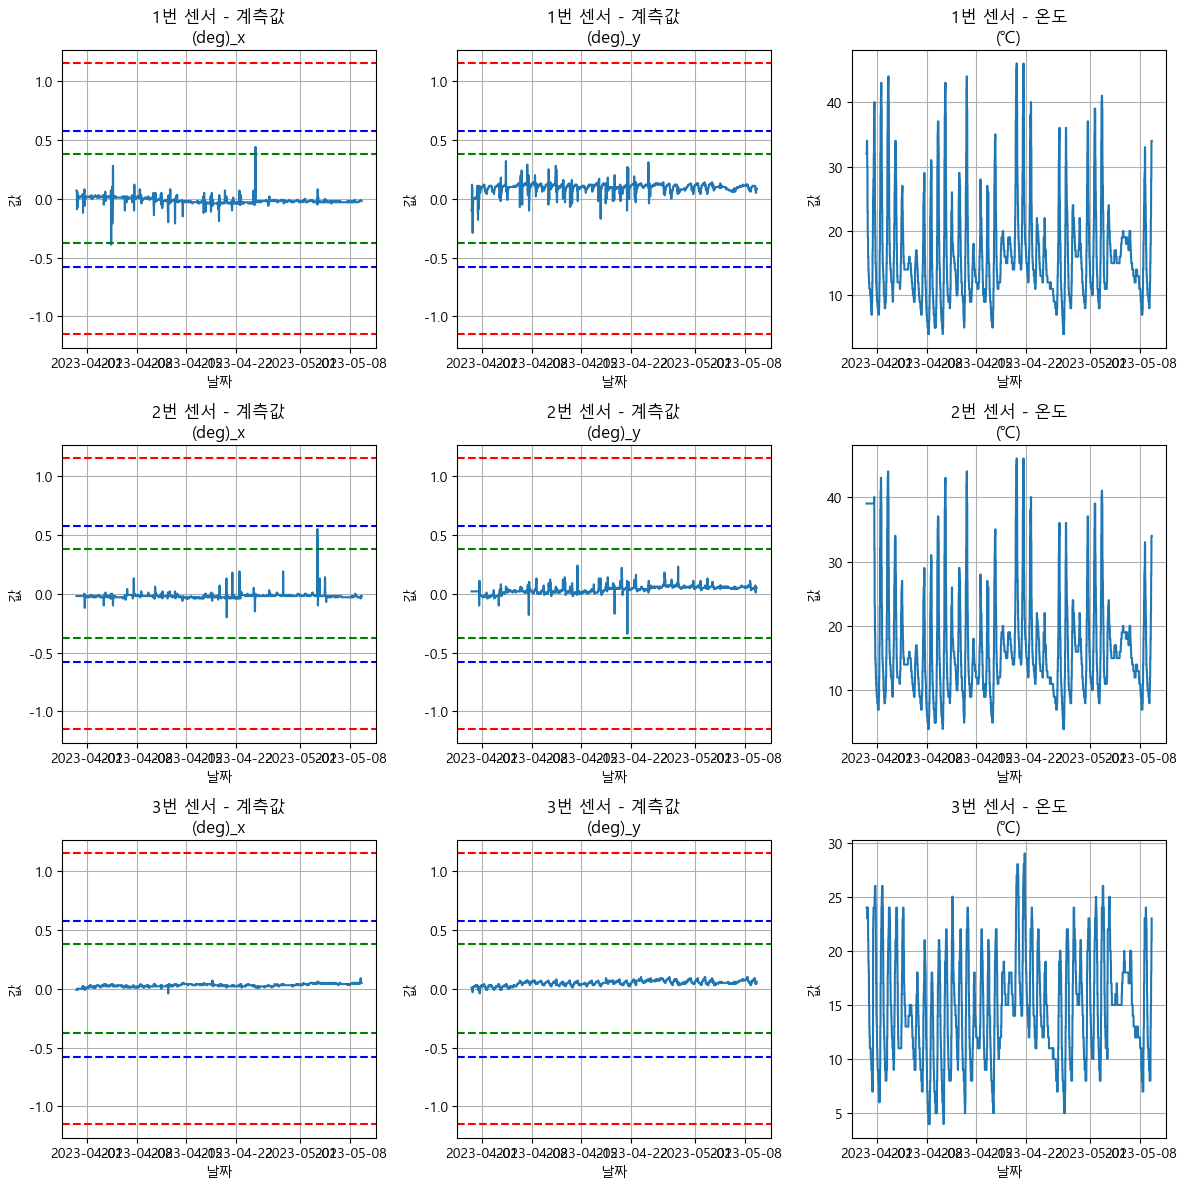

In [86]:
# 폰트 설정
plt.rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

sampling_interval = "1T"  # 원하는 샘플링 간격 설정
result_list = data_pipe_line(sampling_interval)

for region in range(len(result_list)):
    dataframe_name = result_list[region]["file_name"]
    dataframe = result_list[region]["data"]

    # MultiIndex 열별로 플롯 생성
    threshold_3 = 1.15
    threshold_2 = 0.58
    threshold_1 = 0.38
    num_cols = len(dataframe.columns)
    num_rows = (num_cols + 2) // 3  # 3열로 그리드 구성

    fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

    for i, column in enumerate(dataframe.columns):
        sensor, measurement = column
        row = i // 3
        col = i % 3
        ax = axes[row, col] if num_rows > 1 else axes[col]

        ax.plot(dataframe.index, dataframe[column])
        if measurement != "온도\n(℃)":
            ax.axhline(y=threshold_3, color="r", linestyle="--")
            ax.axhline(y=-threshold_3, color="r", linestyle="--")
            ax.axhline(y=threshold_2, color="b", linestyle="--")
            ax.axhline(y=-threshold_2, color="b", linestyle="--")
            ax.axhline(y=threshold_1, color="g", linestyle="--")
            ax.axhline(y=-threshold_1, color="g", linestyle="--")
        ax.set_title(f"{sensor} - {measurement}")
        ax.set_xlabel("날짜")
        ax.set_ylabel("값")
        ax.grid(True)

    # 그리드 간격 조정
    fig.tight_layout()
    print(dataframe_name)
    plt.savefig(f"./plot graph/plot_{dataframe_name[:-5]}.png")
    plt.show()

## 특정 시간대 근처 데이터 탐색 방법

In [17]:
# 주변값 스크리닝
dataframe = result_list[0]["data"]
date = pd.to_datetime("2023-04-19 7:41")
closest_index = min(dataframe.index, key=lambda x: abs(x - date))
window = pd.DateOffset(minutes=30)  # 주변 데이터 시간 간격
start_index = max(dataframe.index[0], closest_index - window)  # 시작 인덱스
end_index = min(dataframe.index[-1], closest_index + window)  # 끝 인덱스
closest_data_range = dataframe.loc[start_index:end_index]
print(dataframe.name)
closest_data_range

광진구.xlsx


1번 센서                     2번 센서                
                    계측값\n(deg)_x 계측값\n(deg)_y 계측값\n(deg)_x 계측값\n(deg)_y   
계측시각                                                                      
2023-04-19 07:10:00          0.1         0.08         0.12        -0.03  \
2023-04-19 07:20:00          0.1         0.08         0.12        -0.03   
2023-04-19 07:30:00          0.1         0.08         0.12        -0.03   
2023-04-19 07:40:00          0.1         0.08         0.00         0.03   
2023-04-19 07:50:00          0.1         0.08         0.00         0.03   
2023-04-19 08:00:00          0.1         0.08         0.00         0.03   
2023-04-19 08:10:00          0.1         0.08         0.00         0.03   

                           3번 센서                     4번 센서                
                    계측값\n(deg)_x 계측값\n(deg)_y 계측값\n(deg)_x 계측값\n(deg)_y   
계측시각                                                                      
2023-04-19 07:10:00         0.12         0.06        -0.03        -0.05  \
2023-04-19 07:20:00         0.12         0.06        -0.03        -0.05   
2023-04-19 07:30:00         0.12         0.06        -0.03        -0.05   
2023-04-19 07:40:00         0.09         0.07        -0.10        -0.15   
2023-04-19 07:50:00         0.09         0.07        -0.10        -0.15   
2023-04-19 08:00:00         0.09         0.06        -0.04        -0.04   
2023-04-19 08:10:00         0.09         0.06        -0.04        -0.04   

                           5번 센서                     6번 센서                
                    계측값\n(deg)_x 계측값\n(deg)_y 계측값\n(deg)_x 계측값\n(deg)_y   
계측시각                                                                      
2023-04-19 07:10:00         0.05         0.01         0.02         0.08  \
2023-04-19 07:20:00         0.05         0.01         0.02         0.08   
2023-04-19 07:30:00         0.05         0.01         0.02         0.08   
2023-04-19 07:40:00         0.05         0.00         0.03         0.06   
2023-04-19 07:50:00         0.05         0.00         0.03         0.06   
2023-04-19 08:00:00         0.05         0.00         0.03         0.06   
2023-04-19 08:10:00         0.05         0.00         0.03         0.06   

                    3단계 기준치_up 3단계 기준치_low  
                                            
계측시각                                        
2023-04-19 07:10:00       1.15       -1.15  
2023-04-19 07:20:00       1.15       -1.15  
2023-04-19 07:30:00       1.15       -1.15  
2023-04-19 07:40:00       1.15       -1.15  
2023-04-19 07:50:00       1.15       -1.15  
2023-04-19 08:00:00       1.15       -1.15  
2023-04-19 08:10:00       1.15       -1.15